# Multi-cell geolift analysis

In [1]:
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

import causalpy as cp
from causalpy.data.simulate_data import generate_multicell_geolift_data

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
pd.set_option("display.precision", 2)
seed = 42

---

In [ ]:
# TEMPORARY CODE TO GENERATE DATA - REMOVE IN FINAL VERSION -----------------------
df = generate_multicell_geolift_data()
df.to_csv("../../../causalpy/data/geolift_multi_cell.csv", index=True)
# ---------------------------------------------------------------------------------

---

## Load the dataset

In [3]:
df = (
    cp.load_data("geolift_multi_cell")
    .assign(time=lambda x: pd.to_datetime(x["time"]))
    .set_index("time")
)

treatment_time = pd.to_datetime("2022-01-01")

# Define the treatment and control geos (the column names)
untreated = [
        "Austria",
        "Belgium",
        "Bulgaria",
        "Croatia",
        "Cyprus",
        "Czech_Republic",
    ]

treated = ["t1", "t2", "t3", "t4"]

df.head()

,Austria,Belgium,Bulgaria,Croatia,Cyprus,Czech_Republic,t1,t2,t3,t4
time,,,,,,,,,,
2019-01-06,3.02,1.73,4.14,3.50,3.11,2.05,3.58,3.09,3.10,3.37
2019-01-13,3.14,1.74,3.93,3.79,3.50,2.01,3.46,3.00,3.20,3.48
2019-01-20,2.79,1.73,4.07,3.75,3.32,1.94,3.49,3.16,2.94,3.15
2019-01-27,2.96,1.73,4.24,3.69,3.28,2.02,3.32,2.91,3.13,3.28
2019-02-03,2.80,1.83,4.20,3.63,3.02,2.33,3.34,3.13,2.94,3.25


Always vizualise the data before starting the analysis.

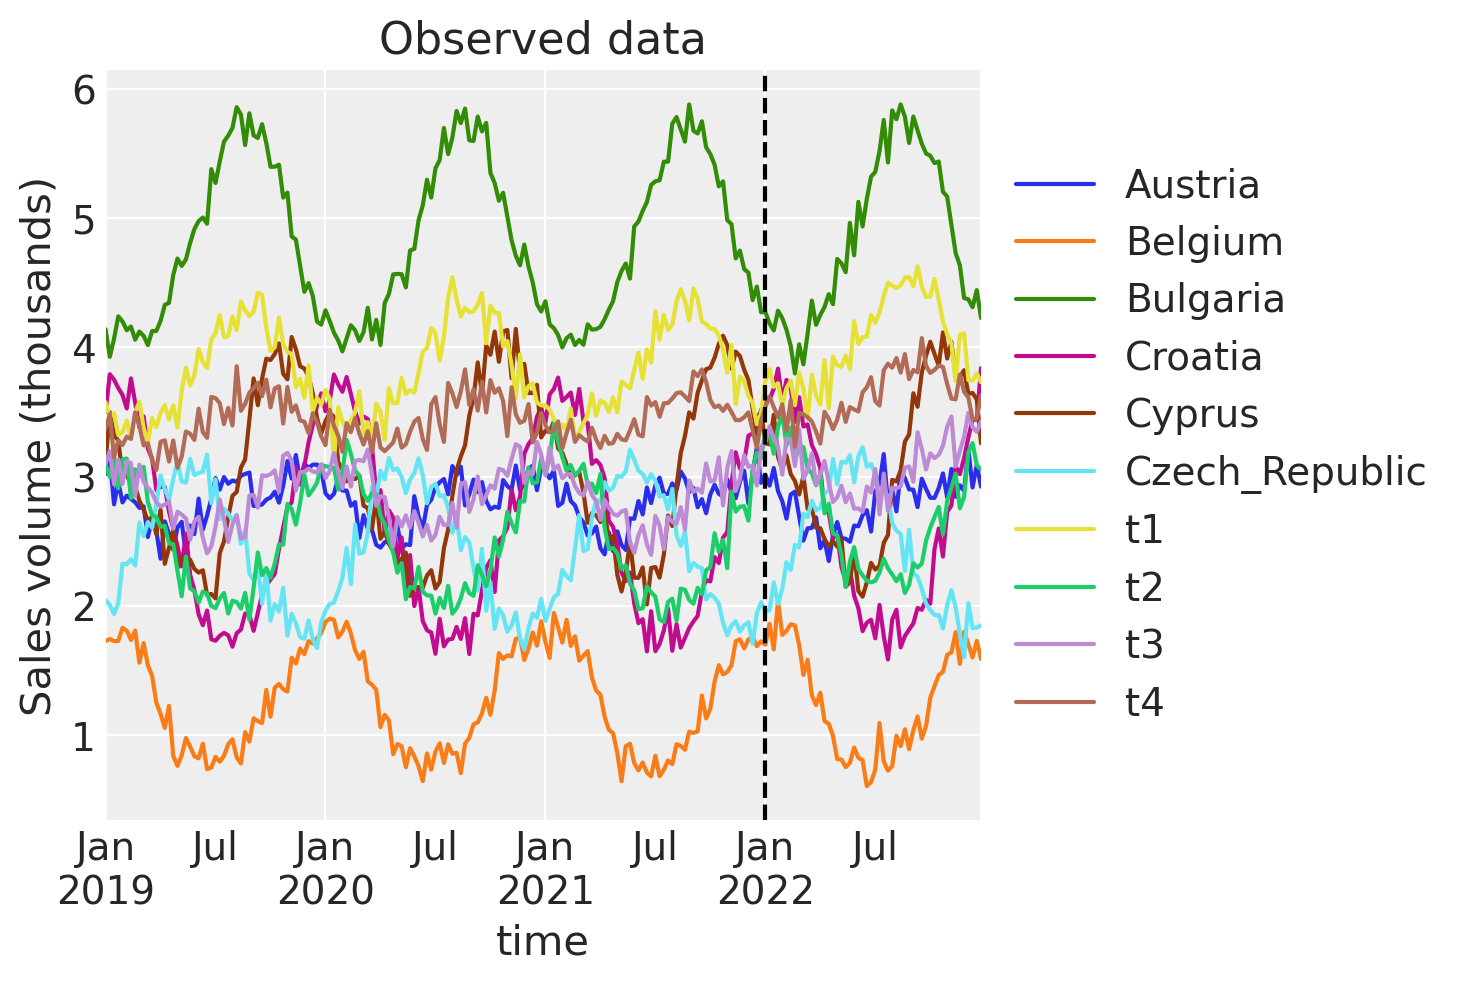

In [4]:
ax = df.plot()
ax.axvline(treatment_time, color="k", linestyle="--")
ax.set(title="Observed data", ylabel="Sales volume (thousands)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

## Approach 1 - individual geo approach

The first analysis approach is to analyze each treated geo individually.

In [5]:
results = []

for i, target_geo in enumerate(treated):
    
    print(f"Analyzing test geo: {target_geo} ({i+1} of {len(treated)})")
    formula = f"{target_geo} ~ 0 + {' + '.join(untreated)}"
    print(formula)
    
    result = cp.pymc_experiments.SyntheticControl(
        df,
        treatment_time,
        formula=formula,
        model=cp.pymc_models.WeightedSumFitter(
            sample_kwargs={"target_accept": 0.95, "random_seed": seed}
        ),
    )
    results.append(result) 

Analyzing test geo: t1 (1 of 4)
t1 ~ 0 + Austria + Belgium + Bulgaria + Croatia + Cyprus + Czech_Republic


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


/Users/benjamv/opt/mambaforge/envs/CausalPy/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Analyzing test geo: t2 (2 of 4)
t2 ~ 0 + Austria + Belgium + Bulgaria + Croatia + Cyprus + Czech_Republic


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


/Users/benjamv/opt/mambaforge/envs/CausalPy/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Analyzing test geo: t3 (3 of 4)
t3 ~ 0 + Austria + Belgium + Bulgaria + Croatia + Cyprus + Czech_Republic


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


/Users/benjamv/opt/mambaforge/envs/CausalPy/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Analyzing test geo: t4 (4 of 4)
t4 ~ 0 + Austria + Belgium + Bulgaria + Croatia + Cyprus + Czech_Republic


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


/Users/benjamv/opt/mambaforge/envs/CausalPy/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Now let's plot the weightings of the untreated geos for each treated geo.

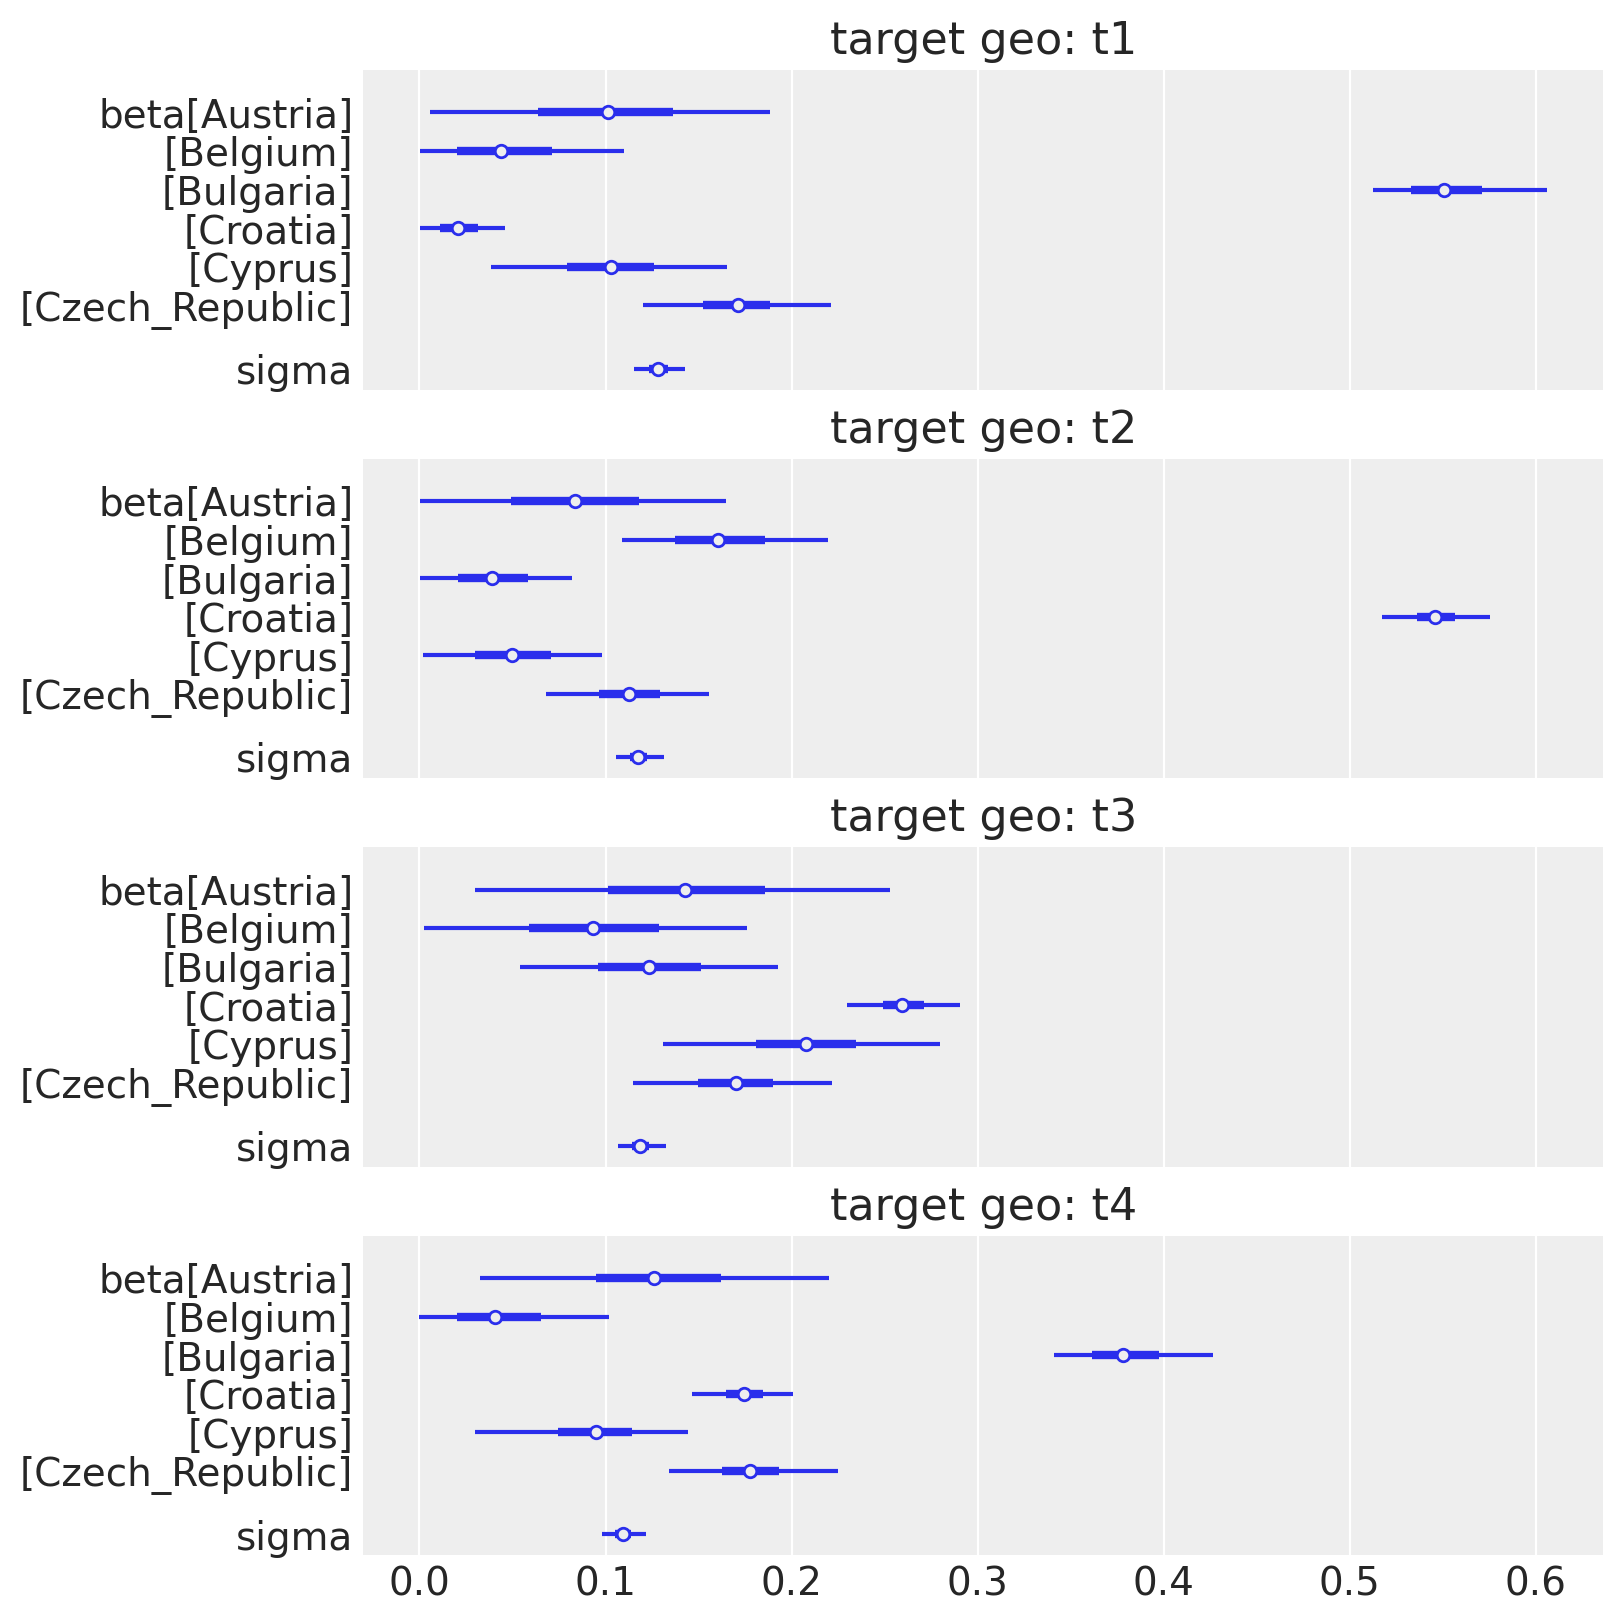

In [6]:
fig, axs = plt.subplots(len(treated), 1, figsize=(8, 2*len(treated)), sharex=True)

for target_geo, ax, result in zip(treated, axs, results):
    az.plot_forest(result.idata, var_names=["~mu"], combined=True, ax=ax)
    ax.set(title=f"target geo: {target_geo}")

And let's also plot the idiomatic causal impact plot for each treated geo.

Causal impact for t1


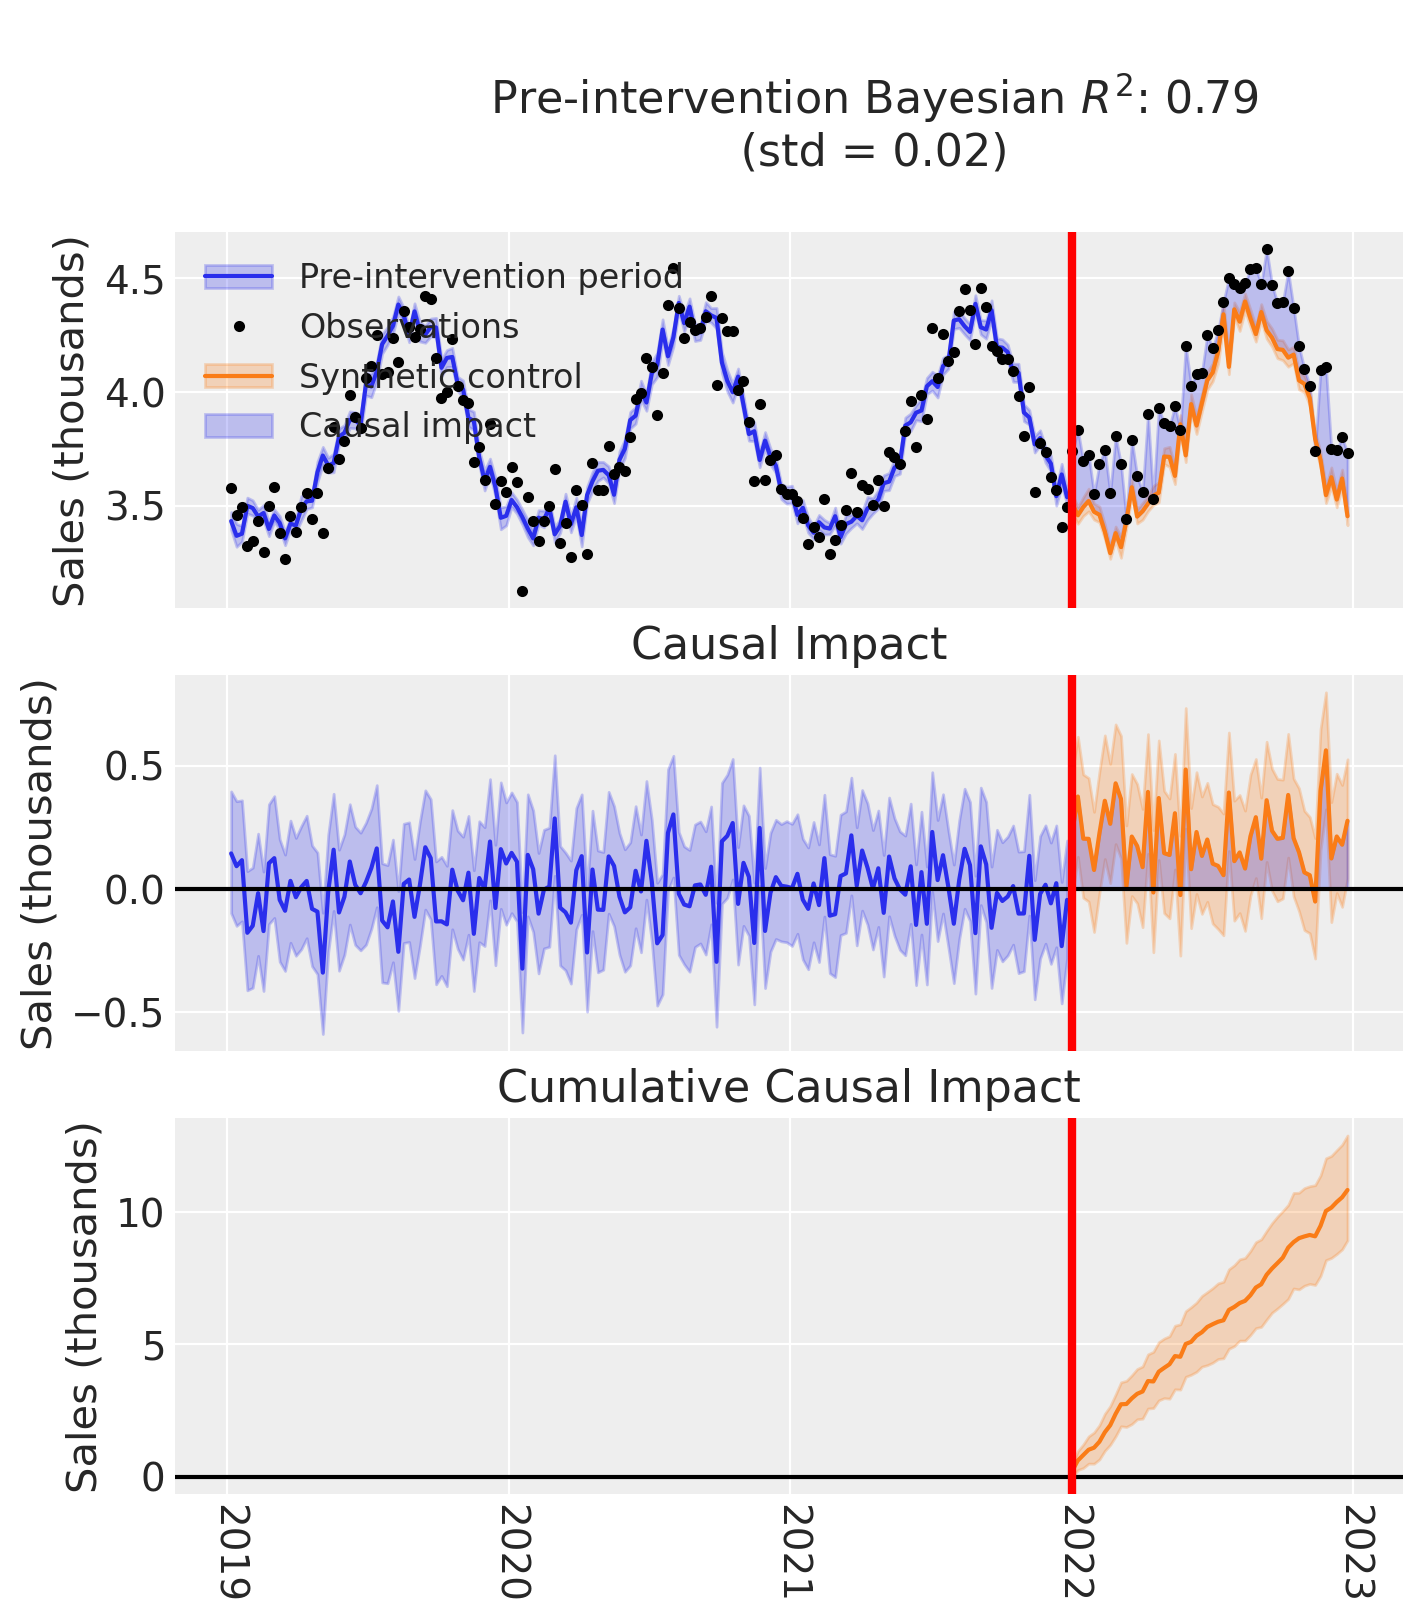

Causal impact for t2


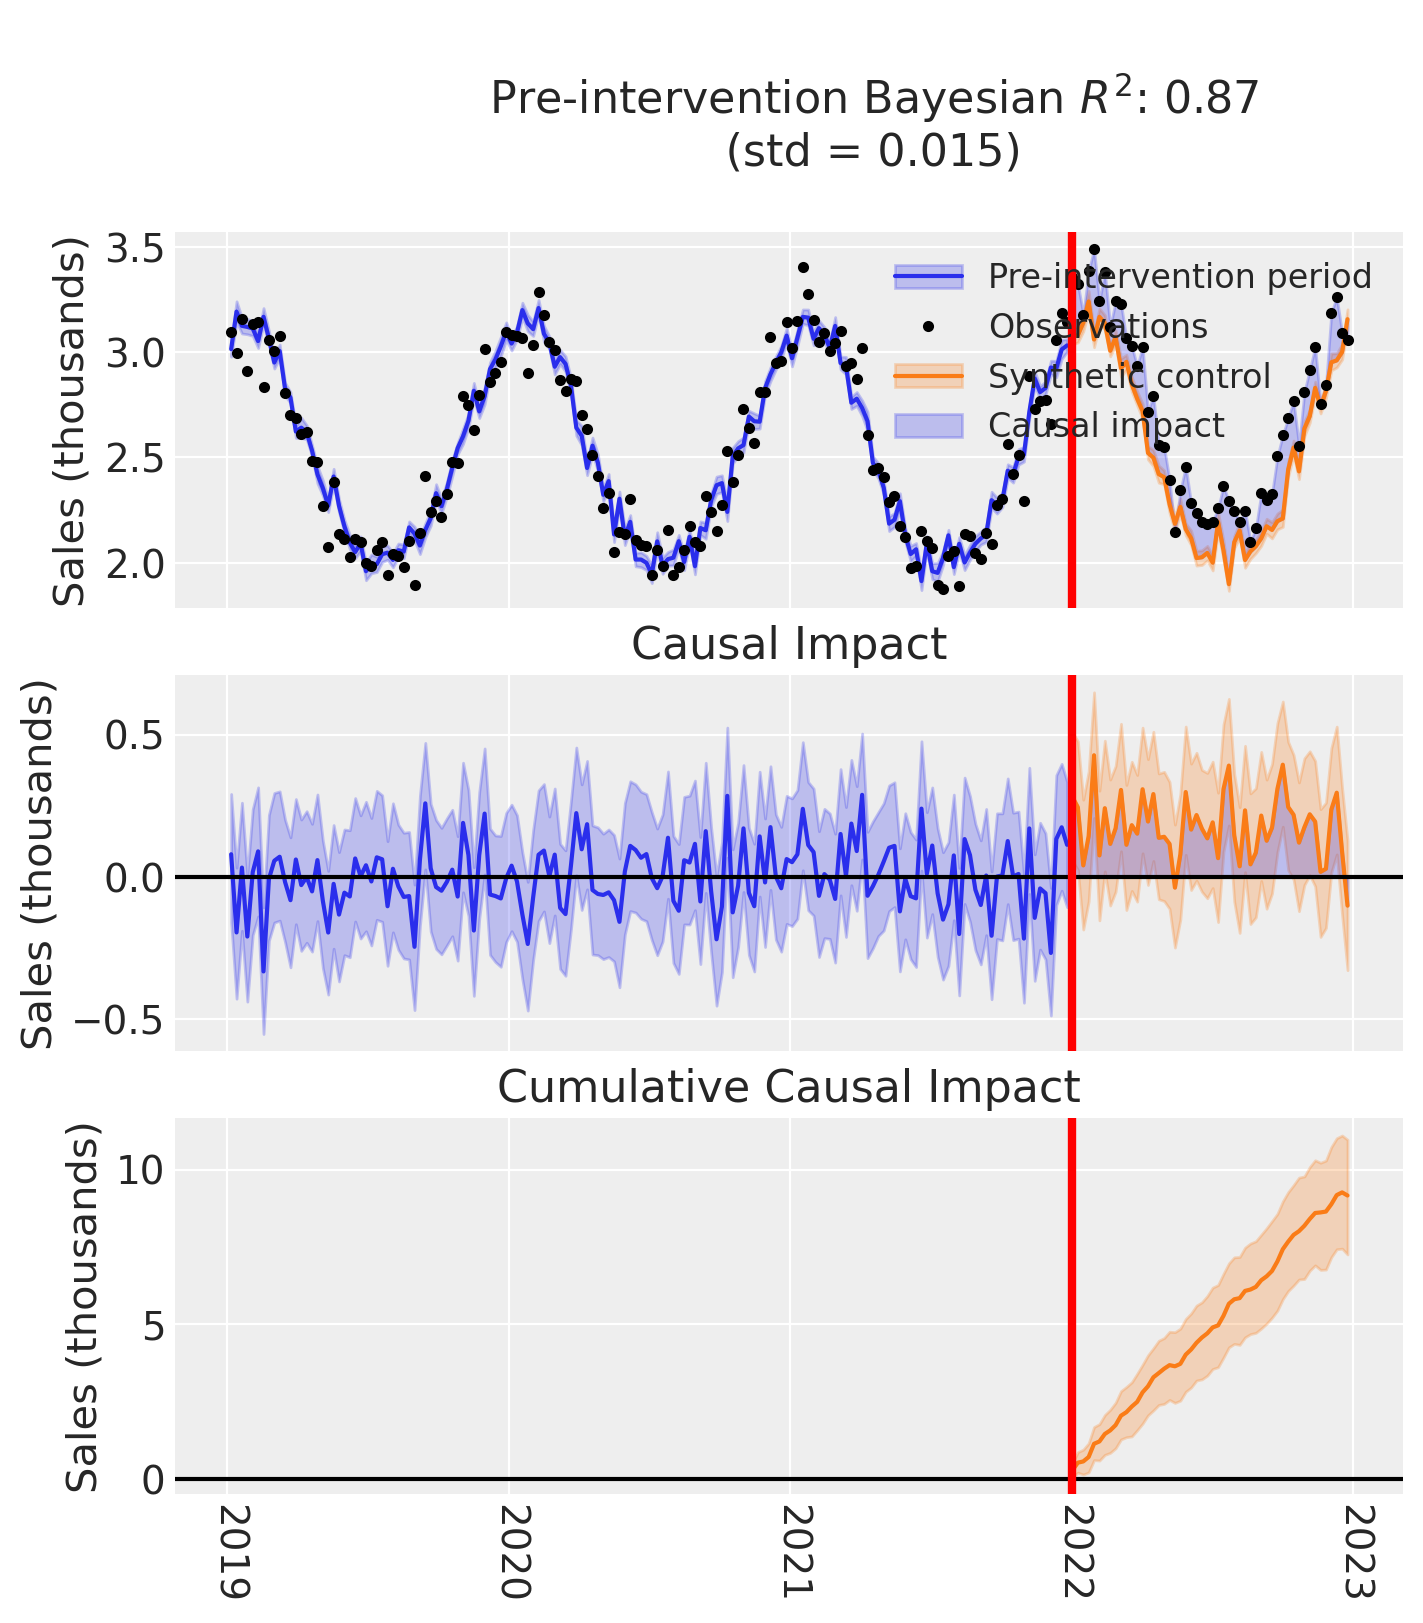

Causal impact for t3


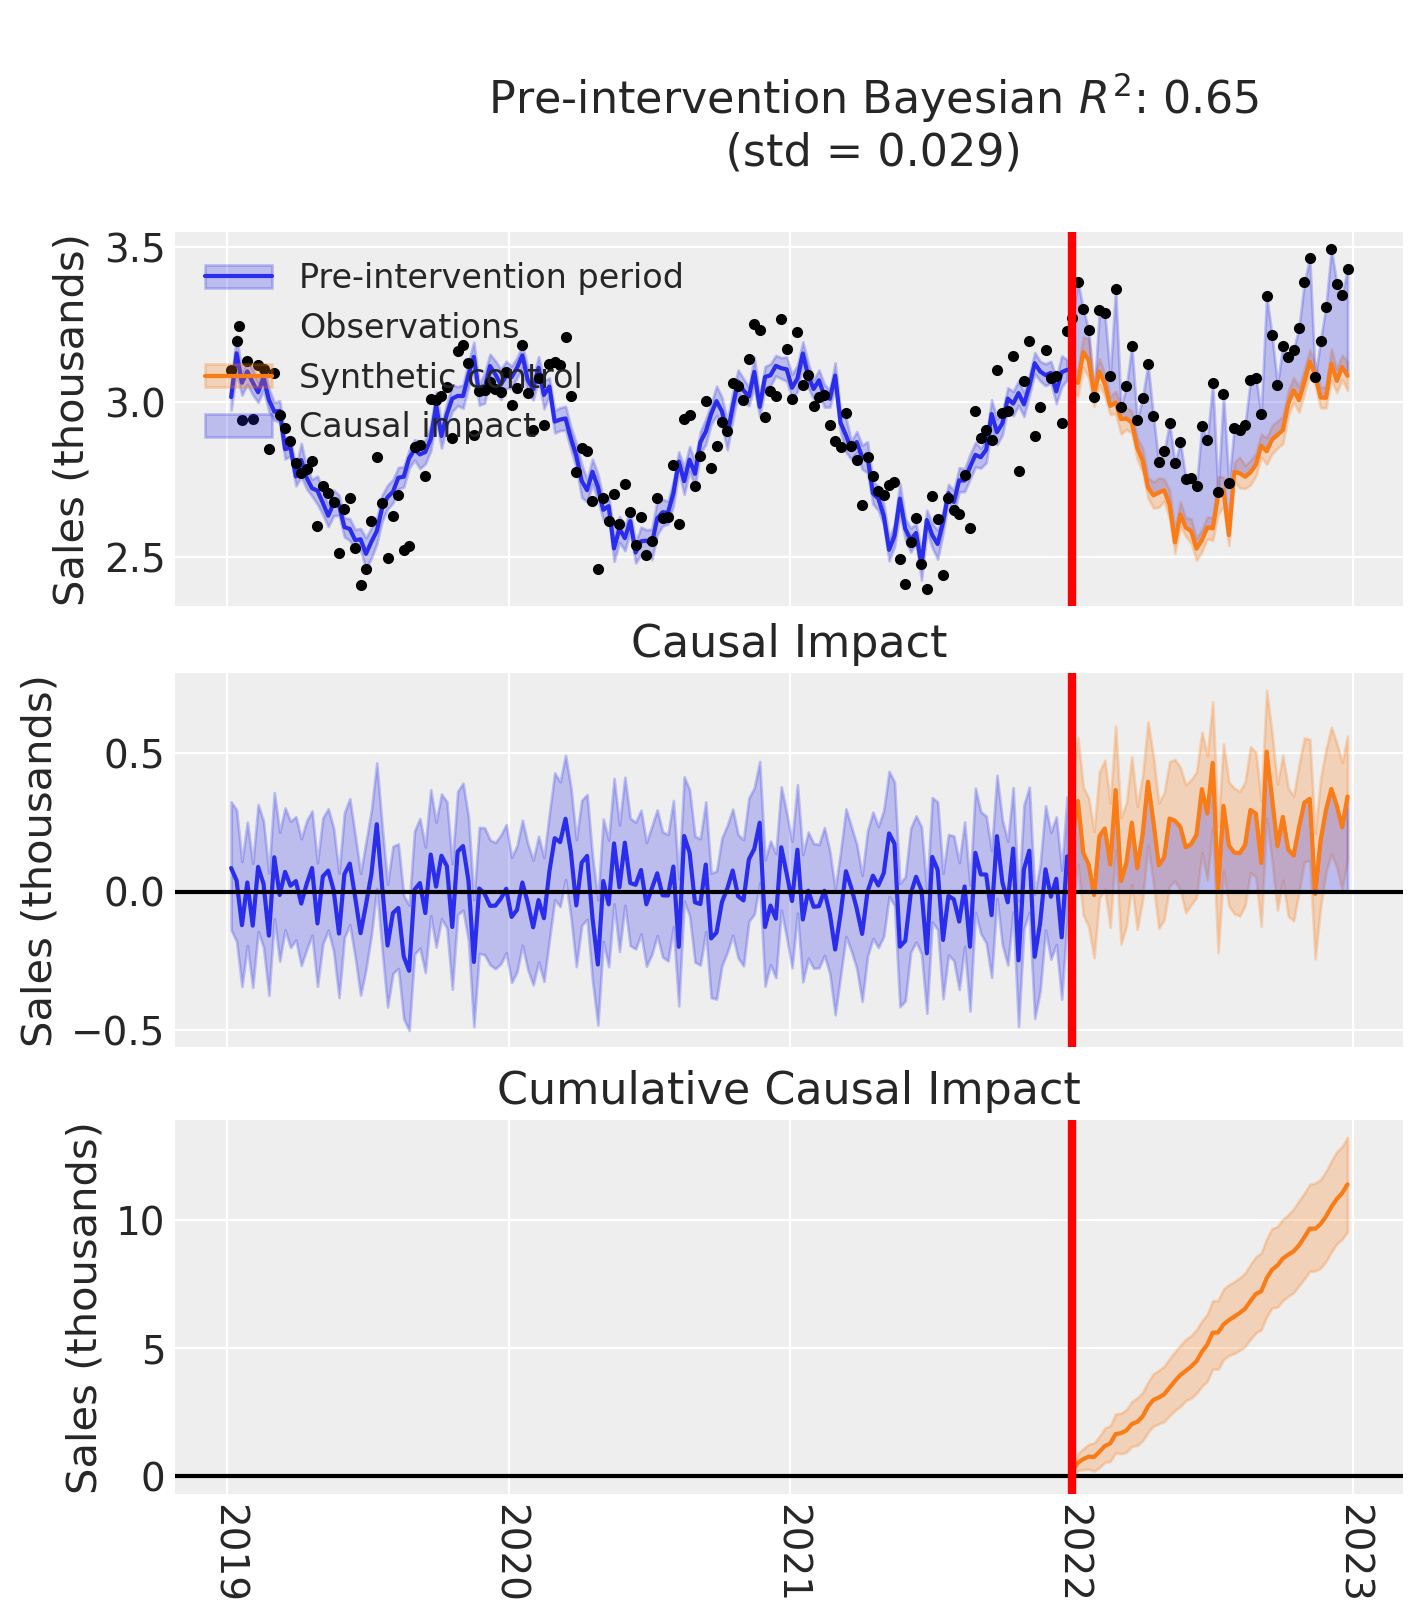

Causal impact for t4


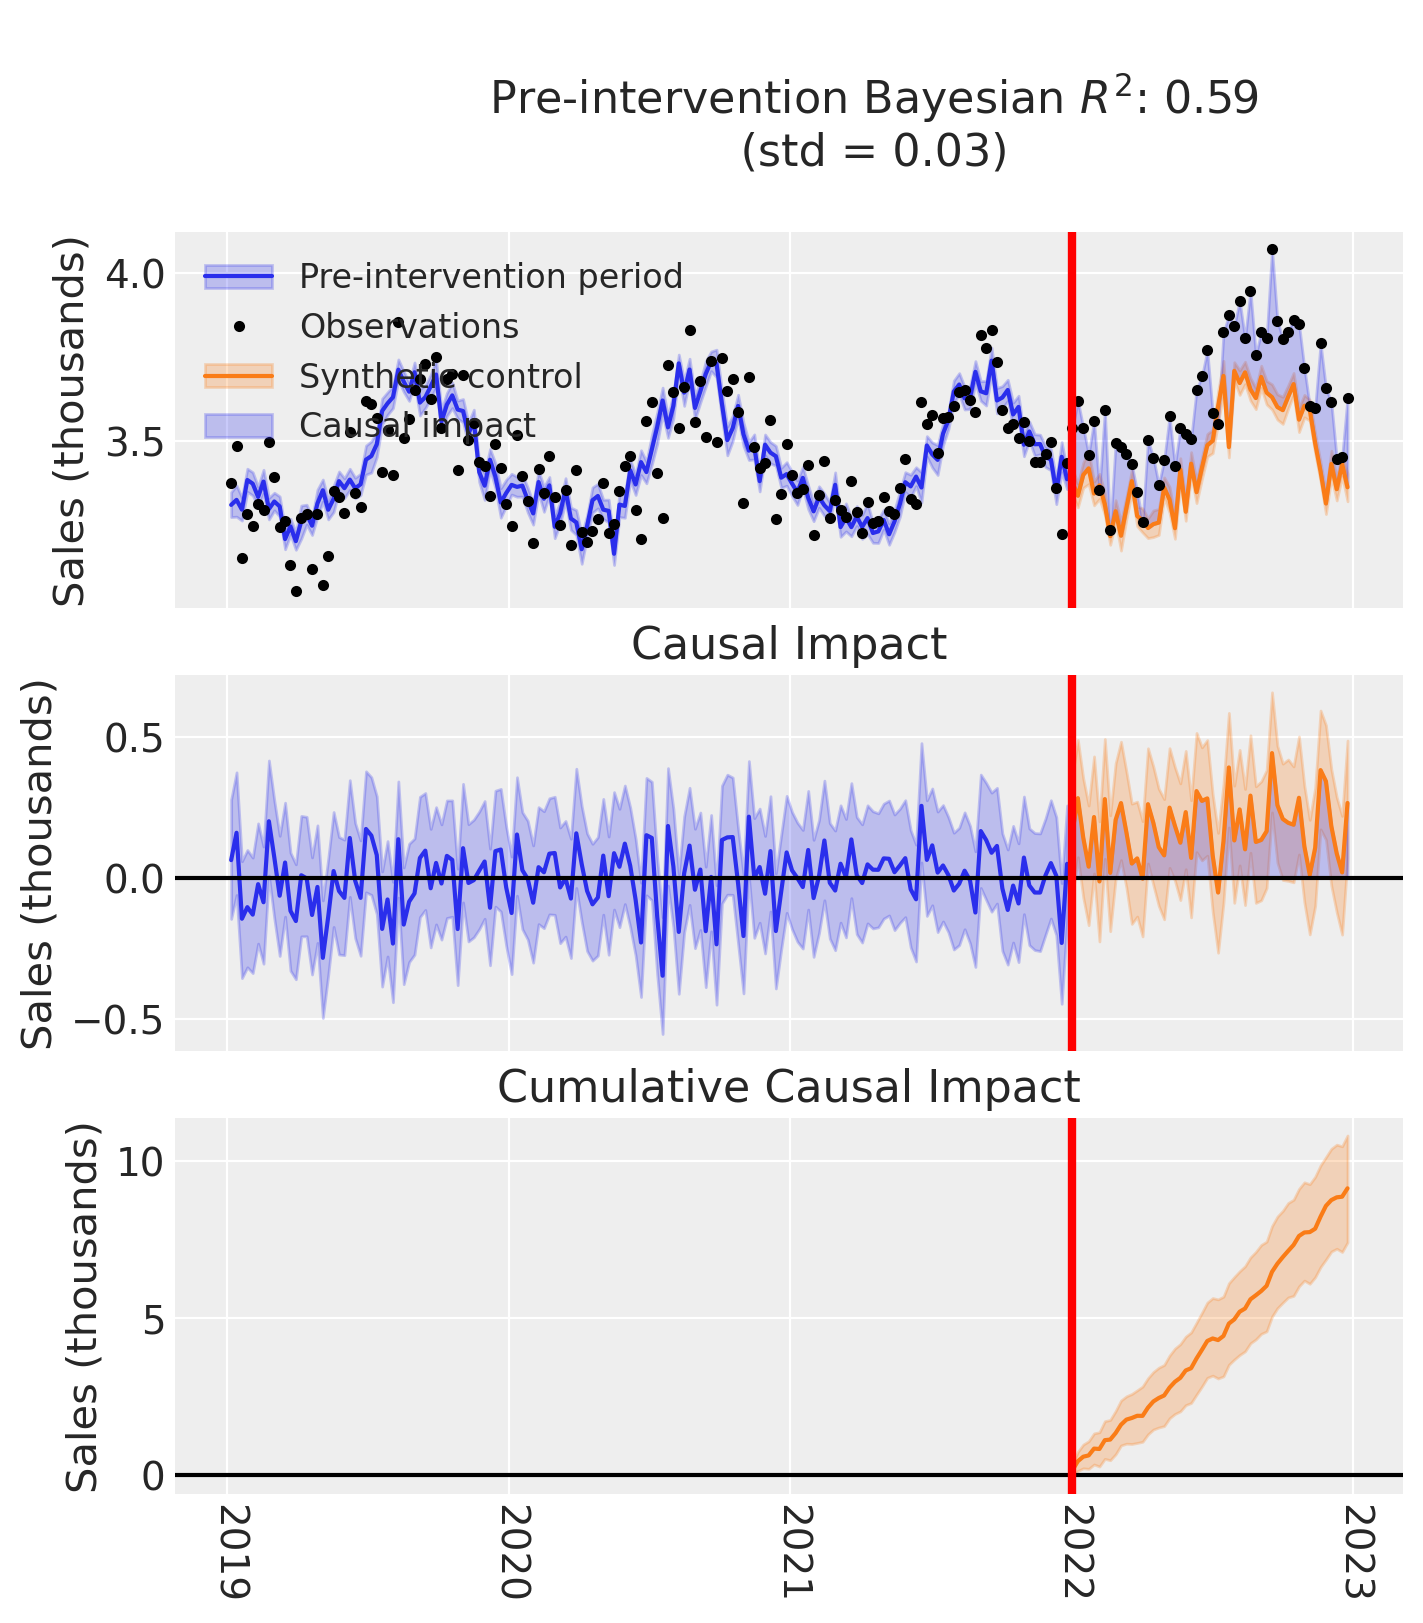

In [7]:
for treated_geo, result in zip(treated, results):

    print(f"Causal impact for {treated_geo}")
    fig, ax = result.plot(plot_predictors=False)

    # formatting
    ax[2].tick_params(axis="x", labelrotation=-90)
    ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax[2].xaxis.set_major_locator(mdates.YearLocator())
    for i in [0, 1, 2]:
        ax[i].set(ylabel="Sales (thousands)")
    plt.show()

We've seen in this section that it is not just possible, but very easy to analyse geo lift result data when there are multiple treated geos. This parricular approach essentially just iterates through each treated geo and analyses them individually.

This does of course mean that if we have a large number of treated geos, we will have a large number of results and plots to look at, but this is fine. 

It could be particularly appropriate if we expect the causal impact of the treatments to vary wildly from one treated geo to the next.

## Approach 2 - aggregated test geo's approach

The second analysis approach is to aggregate the treated geos and analyze them as a group. In the code cell below we will aggregate with the median function, but we can also use the mean. While these are likely to be the most often used aggregation functions, the user is free to use any other function appropriate for a given dataset.

In [8]:
df["treated_agg"] = df[treated].median(axis=1)
df.head()

,Austria,Belgium,Bulgaria,Croatia,Cyprus,Czech_Republic,t1,t2,t3,t4,treated_agg
time,,,,,,,,,,,
2019-01-06,3.02,1.73,4.14,3.50,3.11,2.05,3.58,3.09,3.10,3.37,3.24
2019-01-13,3.14,1.74,3.93,3.79,3.50,2.01,3.46,3.00,3.20,3.48,3.33
2019-01-20,2.79,1.73,4.07,3.75,3.32,1.94,3.49,3.16,2.94,3.15,3.15
2019-01-27,2.96,1.73,4.24,3.69,3.28,2.02,3.32,2.91,3.13,3.28,3.21
2019-02-03,2.80,1.83,4.20,3.63,3.02,2.33,3.34,3.13,2.94,3.25,3.19


Let's vizualise this aggregated geo and compare it to the individual treated geo's.

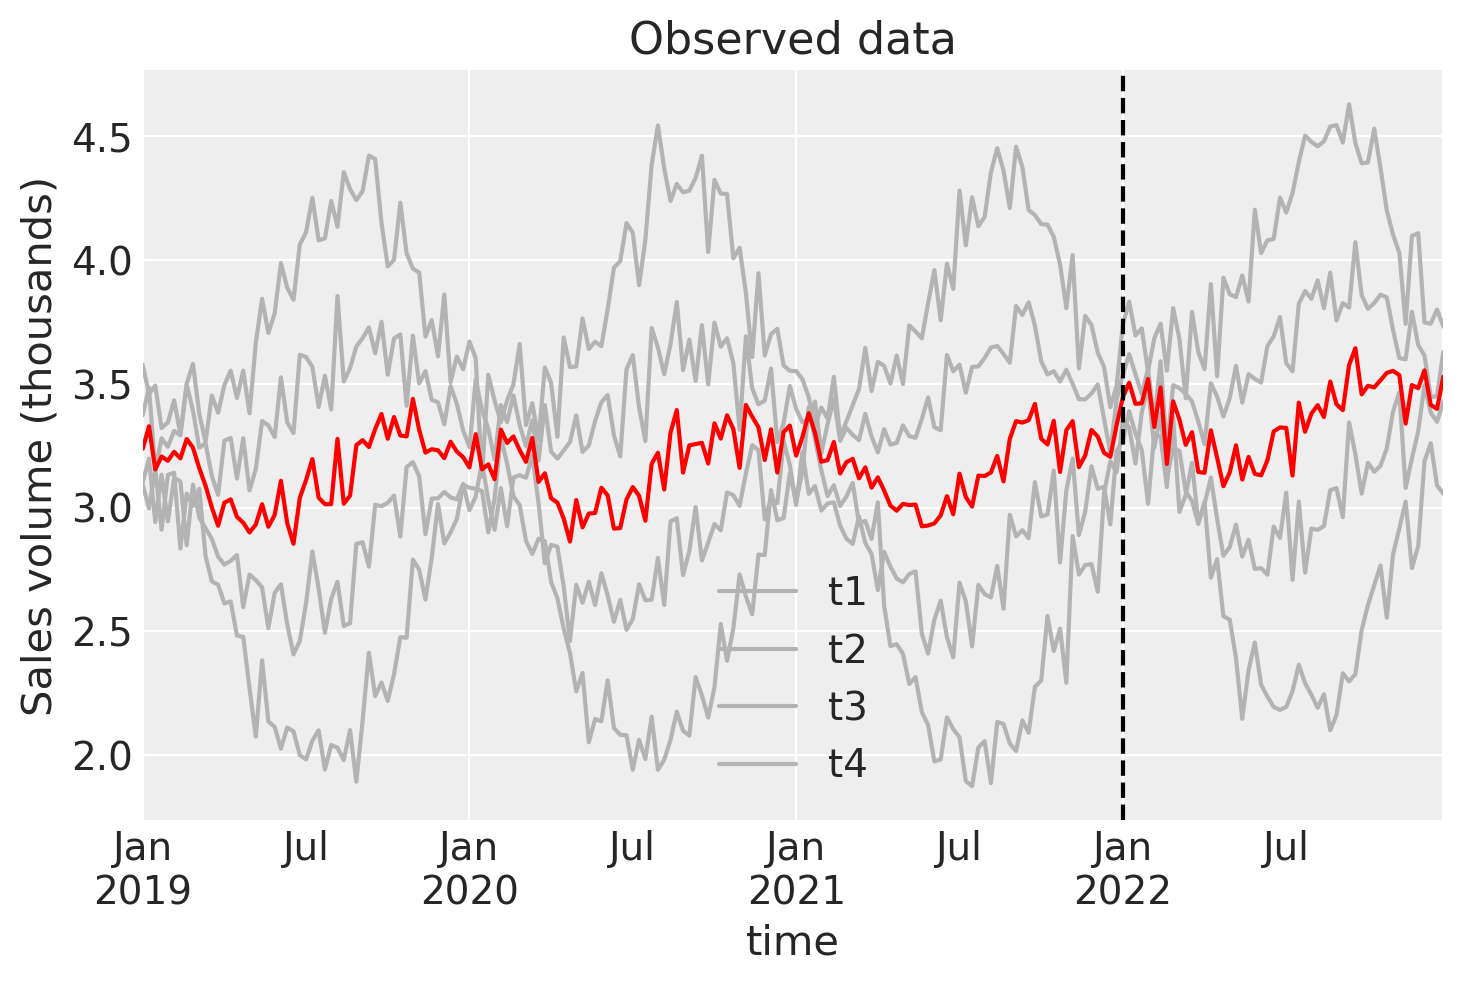

In [9]:
ax = df[treated].plot(color=[0.7, 0.7, 0.7])
df["treated_agg"].plot(color="r", ax=ax)
ax.axvline(treatment_time, color="k", linestyle="--")
ax.set(title="Observed data", ylabel="Sales volume (thousands)");

Now we just proceed with as we would with a regular single-geo analysis.

So first we'll define the model formula - namely that we are modeling the `treated_agg` geo as a function of the untreated geos, and the `0` specifies that we are not using an intercept.

In [10]:
formula = f"treated_agg ~ 0 + {' + '.join(untreated)}"
print(formula)

treated_agg ~ 0 + Austria + Belgium + Bulgaria + Croatia + Cyprus + Czech_Republic


Then we'll fit the model and print the summary.

In [11]:
result = cp.pymc_experiments.SyntheticControl(
    df,
    treatment_time,
    formula=formula,
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


/Users/benjamv/opt/mambaforge/envs/CausalPy/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


In [12]:
result.summary()

==================================Pre-Post Fit==================================
Formula: treated_agg ~ 0 + Austria + Belgium + Bulgaria + Croatia + Cyprus + Czech_Republic
Model coefficients:
Austria                       0.12, 94% HDI [0.023, 0.21]
Belgium                       0.075, 94% HDI [0.0097, 0.15]
Bulgaria                      0.26, 94% HDI [0.21, 0.32]
Croatia                       0.24, 94% HDI [0.22, 0.27]
Cyprus                        0.13, 94% HDI [0.077, 0.19]
Czech_Republic                0.16, 94% HDI [0.12, 0.2]
sigma                         0.086, 94% HDI [0.078, 0.096]


We can see the model weightings visually like this:

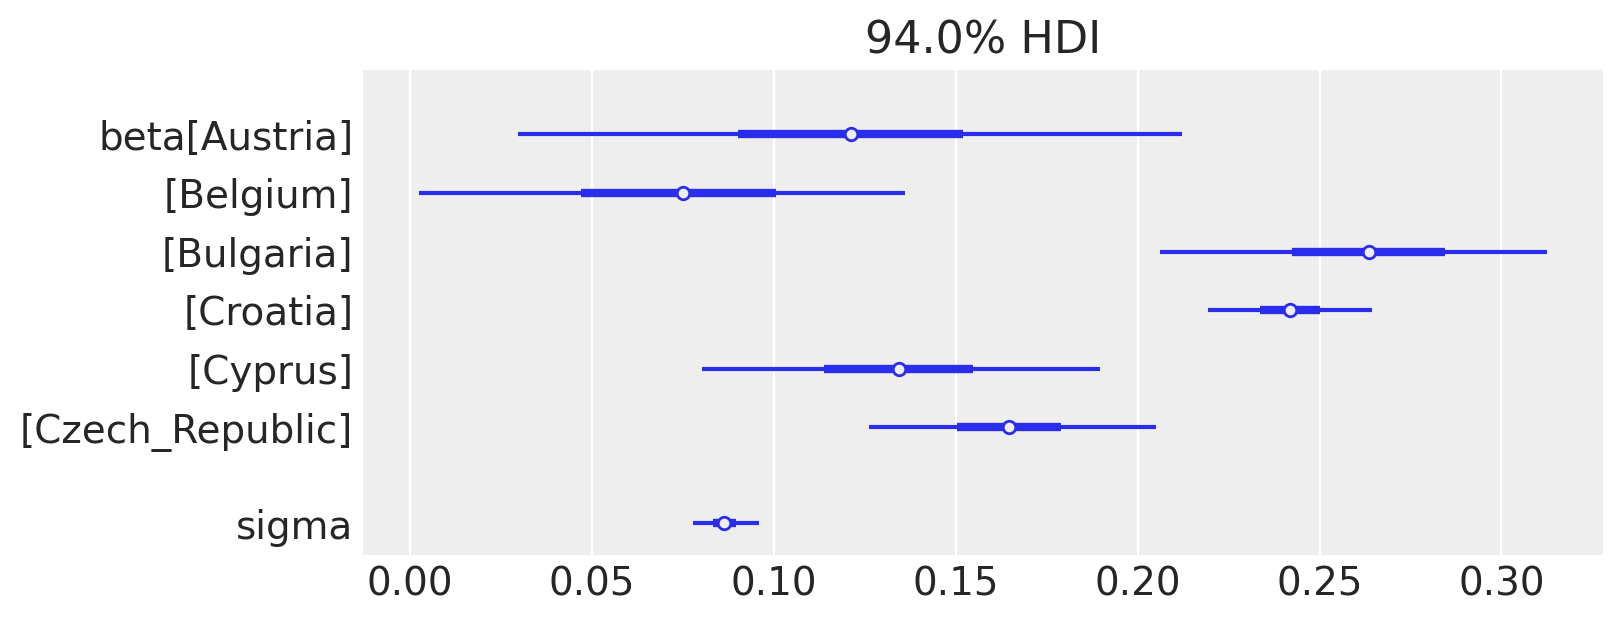

In [13]:
az.plot_forest(result.idata, var_names=["~mu"], figsize=(8, 3), combined=True);

And of course we can see the causal impact plot using the `.plot` method.

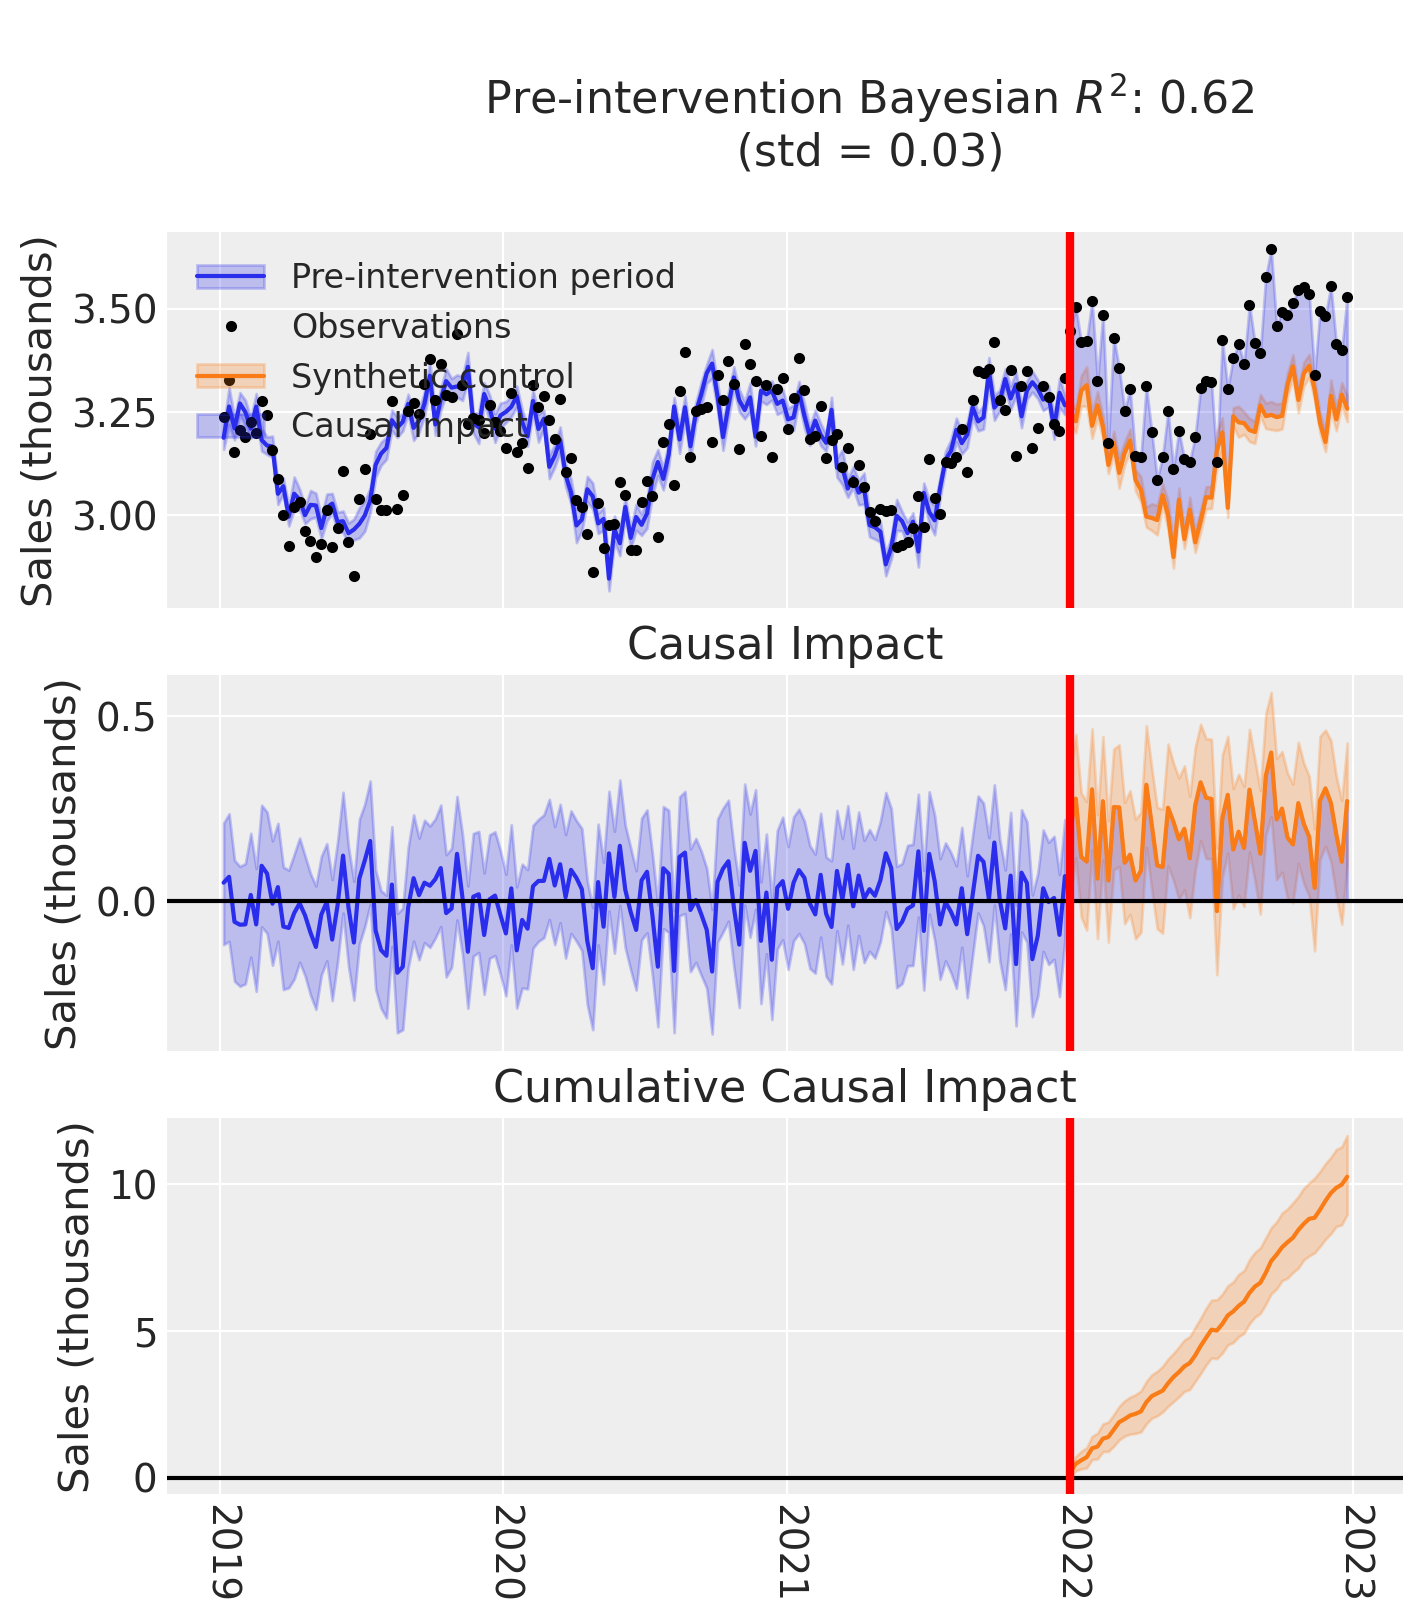

In [14]:
fig, ax = result.plot(plot_predictors=False)

# formatting
ax[2].tick_params(axis="x", labelrotation=-90)
ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax[2].xaxis.set_major_locator(mdates.YearLocator())
for i in [0, 1, 2]:
    ax[i].set(ylabel="Sales (thousands)")

## Summary

We've shown two methods that we can use to analyse geo lift data with multiple treated geos. To do this, we used a simulated dataset with seasonality and observation noise.

The first method is to analyze each treated geo individually. This is useful when we want to understand the impact of each geo separately. This may make most sense if the treatments were different in kind or magnitude. That is, when we do not expect the effects of the intervention to be similar in each treated region.

The second method is to aggregate the treated geos and analyze them as a single aggregated geo. This is useful when we expect the effects of the intervention to be similar in each treated region - for example if we depoloyed the same kind and magnitude of intervention in each treated region. This method is also useful when we have a large number of treated geos and we want to reduce the number of models we need to fit and create a single 'story' for the causal effects of the treatment across all treated geos.